# 1. Imports and setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

# 2. Data preparation function

In [2]:
import joblib
from skimage.io import imread
from skimage.transform import resize

def resize_all_from_files(file_list, pklname, width=150, height=None):
    height = height if height is not None else width
    data = dict()
    data['description'] = f'resized ({width}x{height}) leaf images in rgb'
    data['label'] = []
    data['filename'] = []
    data['data'] = []
    for file in file_list:
        im = imread(file)
        im = resize(im, (width, height))
        label = os.path.basename(file).split('_leaf_')[0].replace(' ', '_')
        data['label'].append(label)
        data['filename'].append(os.path.basename(file))
        data['data'].append(im)
    pklname = f"{pklname}_{width}x{height}px.pkl"
    print(f"Processed {len(data['data'])} images")
    joblib.dump(data, pklname)
    return data

# 3. Load and process the data (Taking 6 Class)

In [3]:
import glob
src_path = r"E:\\dataset\\LeafDataset"
selected_classes = [
    'Acer palmatum',
    'Ginkgo biloba',
    'Magnolia grandiflora l',
    'Firmiana simplex',
    'Salix babylonica',
    'Cedrus deodara'
]
all_files = glob.glob(src_path + "\\train\\img\\*.jpg") + glob.glob(src_path + "\\val\\img\\*.jpg")
print("Total files found (unfiltered):", len(all_files))
# print("Sample unfiltered files:", all_files[:5])

filtered_files = [f for f in all_files if any(cls.lower() in os.path.basename(f).lower() for cls in selected_classes)]
print("Total files found for 6 classes:", len(filtered_files))
# print("Sample filtered files:", filtered_files[:5])

if filtered_files:
    resize_all_from_files(filtered_files, "leaf_dataset_6classes")
else:
    print("No matching files. Check class names or path.")


Total files found (unfiltered): 638
Total files found for 6 classes: 64
Processed 64 images


# 4. Load processed data and visualize

Data description: resized (150x150) leaf images in rgb
Number of images: 64
Unique classes: 6


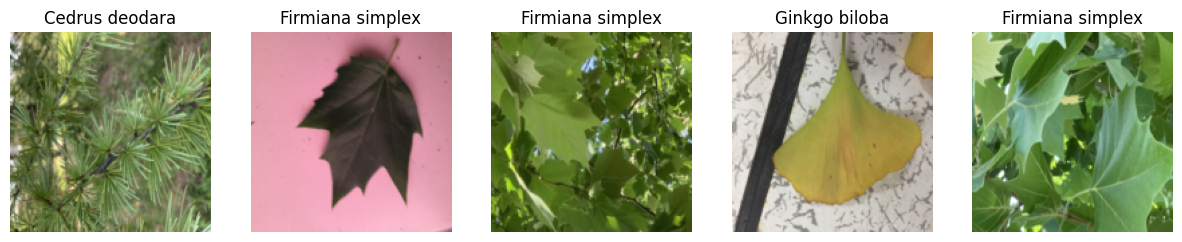

In [4]:
import random
data = joblib.load("leaf_dataset_6classes_150x150px.pkl")
print("Data description:", data['description'])
print("Number of images:", len(data['data']))
print("Unique classes:", len(set(data['label'])))

if len(data['data']) > 0:
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        idx = random.randint(0, len(data['data']) - 1)
        axs[i].imshow(data['data'][idx])
        axs[i].set_title(data['label'][idx].replace('_', ' '))
        axs[i].axis('off')
    plt.show()
else:
    print("No images found. Check path or file formats.")
# print(data['filename'])

## 4.1 Data Augmentation

In [5]:
from skimage.transform import rotate
from skimage.exposure import adjust_gamma
augmented_data = {'label': [], 'filename': [], 'data': []}
for i, (img, lbl, fname) in enumerate(zip(data['data'], data['label'], data['filename'])):
    augmented_data['data'].append(img)
    augmented_data['label'].append(lbl)
    augmented_data['filename'].append(fname)
    augmented_data['data'].append(rotate(img, 90))
    augmented_data['label'].append(lbl)
    augmented_data['filename'].append(f"{fname}_rot90")
    augmented_data['data'].append(rotate(img, 180))
    augmented_data['label'].append(lbl)
    augmented_data['filename'].append(f"{fname}_rot180")
    augmented_data['data'].append(rotate(img, 270))
    augmented_data['label'].append(lbl)
    augmented_data['filename'].append(f"{fname}_rot270")
    augmented_data['data'].append(np.fliplr(img))
    augmented_data['label'].append(lbl)
    augmented_data['filename'].append(f"{fname}_flipH")
    augmented_data['data'].append(adjust_gamma(img, gamma=0.8))
    augmented_data['label'].append(lbl)
    augmented_data['filename'].append(f"{fname}_bright08")
    augmented_data['data'].append(adjust_gamma(img, gamma=1.2))
    augmented_data['label'].append(lbl)
    augmented_data['filename'].append(f"{fname}_bright12")
data = augmented_data
print("Number of images after enhanced augmentation:", len(data['data']))

Number of images after enhanced augmentation: 448


# 5. Prepare data for training

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog

# X = np.array(data['data']).reshape((len(data['data']), -1))  # Flatten images
# y = np.array(data['label'])
# Using HOG instead of Pixel Flattening

X = []
for img in data['data']:
    # Optional: convert to grayscale if needed
    if len(img.shape) == 3 and img.shape[2] == 3:
        from skimage.color import rgb2gray
        img = rgb2gray(img)

    # Extract HOG features
    features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')
    X.append(features)

X = np.array(X)
le = LabelEncoder()
y = le.fit_transform(data['label'])  # Converts species names to 0, 1, 2, ...

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# After train_test_split in Section 5
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Unique classes in y_train:", len(set(y_train)))
print("Unique classes in y_test:", len(set(y_test)))

# print("Sample labels:", y[50:55])
# print("Label data type:", type(y[0]))

# print(len(X[:2][0]))
# print(X[:2][0])

# Before Hog, the feature space was 67500, after HOG the feature space is: 10404
# X contain textures and shapes numerical value

Training set size: 358
Test set size: 90
Unique classes in y_train: 6
Unique classes in y_test: 6


# 6. Train classifier (Stochastic Gradient Descent Classifier)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

# Random Forest Classifier 
# clf = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Increased to 100
# ])
# clf.fit(X_train, y_train)

# Stochastic Gradient Descent Classifier
# Create the pipeline with SGDClassifier using default parameters
clf = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('classifier', SGDClassifier(class_weight='balanced',random_state=42))  # Use SGDClassifier with default parameters
])
clf.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 SGDClassifier(class_weight='balanced', random_state=42))])

# 7. Evaluate classifier

,precision,recall,f1-score,support
Acer_palmatum,0.375000,0.461538,0.413793,13.000000
Cedrus_deodara,0.733333,0.916667,0.814815,12.000000
Firmiana_simplex,0.733333,0.687500,0.709677,16.000000
Ginkgo_biloba,0.666667,0.727273,0.695652,11.000000
Magnolia_grandiflora_L,0.833333,0.500000,0.625000,20.000000
Salix_babylonica,0.550000,0.611111,0.578947,18.000000
accuracy,0.633333,0.633333,0.633333,0.633333
macro avg,0.648611,0.650681,0.639647,90.000000
weighted avg,0.658981,0.633333,0.634279,90.000000


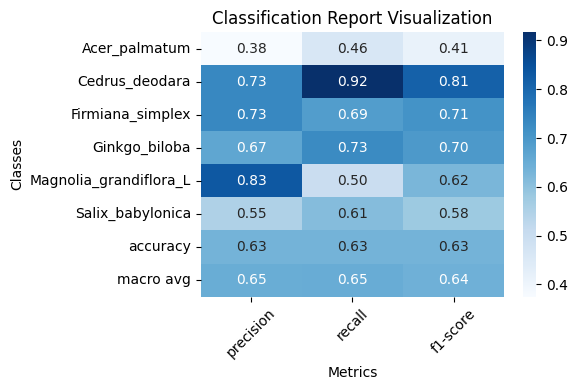

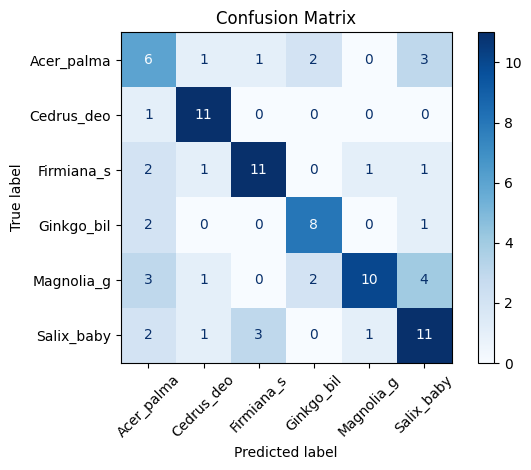

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test)
#  print("Predicted label:", le.inverse_transform([y_pred[0]]))

# Generate classification report dictionary
report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0, output_dict=True)

# Convert the classification report into a pandas dataframe
report_df = pd.DataFrame(report).transpose()
display(report_df)
# Plot a heatmap for visualization
plt.figure(figsize=(6, 4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Classification Report Visualization")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, y_pred)

# Plot (with class names shortened for display)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[lbl[:10] for lbl in le.classes_])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 8. Evaluate on test set

Processed 15 images
Test set evaluation:
                        precision    recall  f1-score   support

         Acer_palmatum       0.00      0.00      0.00         2
        Cedrus_deodara       0.00      0.00      0.00         1
      Firmiana_simplex       0.00      0.00      0.00         4
         Ginkgo_biloba       0.00      0.00      0.00         2
Magnolia_grandiflora_L       0.38      0.75      0.50         4
      Salix_babylonica       0.50      0.50      0.50         2

              accuracy                           0.27        15
             macro avg       0.15      0.21      0.17        15
          weighted avg       0.17      0.27      0.20        15

{np.str_('Cedrus_deodara'), np.str_('Firmiana_simplex'), np.str_('Magnolia_grandiflora_L'), np.str_('Ginkgo_biloba'), np.str_('Acer_palmatum'), np.str_('Salix_babylonica')}
6


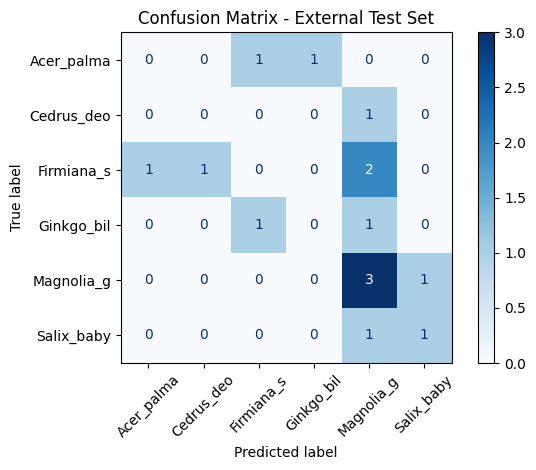

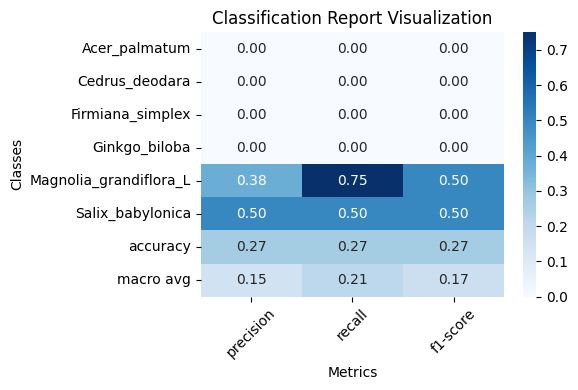

In [14]:
import glob
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_src_path = r"E:\\dataset\\LeafDataset\\test\\img"
test_files_unfiltered = glob.glob(os.path.join(test_src_path, "*.jpg"))

# Filter test files based on selected classes
test_files = [
    f for f in test_files_unfiltered
    if any(cls.lower() in os.path.basename(f).lower() for cls in selected_classes)
]

# Error handling
if not os.path.exists(test_src_path):
    print(f"Test path does not exist: {test_src_path}")
elif not test_files_unfiltered:
    print(f"No .jpg files found in test folder.")
elif not test_files:
    print(f"Test images found, but none match selected classes: {selected_classes}")
else:
    # Load and preprocess test data
    test_data = resize_all_from_files(test_files, "leaf_dataset_6classes_test")

    X_test_full = []
    for img in test_data['data']:
        if len(img.shape) == 3:
            img = rgb2gray(img)
        features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')
        X_test_full.append(features)
    
    X_test_full = np.array(X_test_full)
    y_test_full = np.array(test_data['label'])

    # If you used LabelEncoder before, encode test labels too
    if 'le' in globals():
        y_test_full = le.transform(y_test_full)

    # Predict
    y_pred_test = clf.predict(X_test_full)

    # Report
    print("Test set evaluation:")
    print(classification_report(y_test_full, y_pred_test, target_names=le.classes_, zero_division=0))
    print(set(le.inverse_transform(y_test_full)))
    print(len(set(le.inverse_transform(y_test_full))))
    # Confusion Matrix
    cm = confusion_matrix(y_test_full, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[lbl[:10] for lbl in le.classes_])
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix - External Test Set")
    plt.tight_layout()
    plt.show()

# Generate classification report dictionary
report = classification_report(y_test_full, y_pred_test, target_names=le.classes_, zero_division=0, output_dict=True)

# Convert the classification report into a pandas dataframe
report_df = pd.DataFrame(report).transpose()

# Plot a heatmap for visualization
plt.figure(figsize=(6, 4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Classification Report Visualization")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 9. Hyperparameter tuning using GridSearchCV
* to Find the best combinations of hyperparameters for our dataset

In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Create the pipeline with SGDClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('classifier', SGDClassifier(random_state=42))  # Use SGDClassifier instead of SVC
])

# Define the parameter grid for SGDClassifier
param_grid = {
    'classifier__loss': ['hinge', 'log_loss', 'squared_hinge'],  # replaced 'log' with 'log_loss'
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__max_iter': [1000, 2000],
    'classifier__tol': [1e-3, 1e-4],
}

# Perform GridSearchCV to find the best hyperparameters
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

# Print best hyperparameters and best cross-validation score
print("Best parameters:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

# Use the best model
best_model = grid.best_estimator_
print("Test accuracy:", best_model.score(X_test, y_test))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'classifier__alpha': 0.01, 'classifier__loss': 'squared_hinge', 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__tol': 0.001}
Best cross-val accuracy: 0.5865414710485133
Test accuracy: 0.6333333333333333


              precision    recall  f1-score   support

           0       1.00      0.27      0.42        15
           1       0.88      0.78      0.82         9
           2       0.65      0.68      0.67        19
           3       0.37      0.91      0.53        11
           4       0.44      0.31      0.36        13
           5       0.64      0.58      0.61        12

    accuracy                           0.57        79
   macro avg       0.66      0.59      0.57        79
weighted avg       0.67      0.57      0.56        79



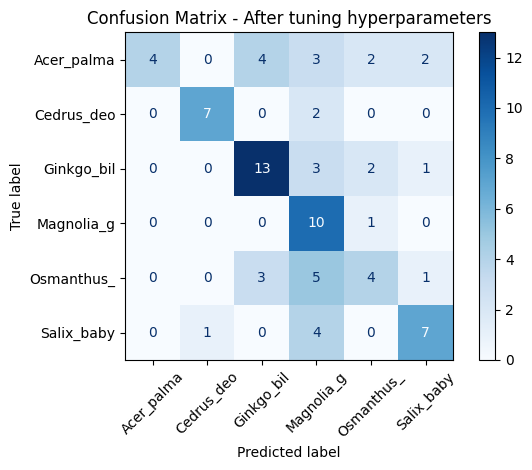

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

# Print a detailed classification report
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[lbl[:10] for lbl in le.classes_])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - After tuning hyperparameters")
plt.tight_layout()
plt.show()

27-57

# 10.  The performance on the leaf dataset can be improved using -
* HOG Feature Extraction Technique instead of taking flatten image. It computes edges and then creates histogram of gradient orientation in small region. It captures the structure and shapes of the object and reduce dimension (Features Space)
* Use Neural Network such as VGG16 (CNN) to extract high level features i.g shapes, images. VGG16 extracts Compact Feature Vector (i.e. 4096 features per image from it's fully connected layer). It captures semantic info (like "this looks like mango leaf") and this is more meaningful. It improving model performance and reduce overfitting.
* SMOTE Technique to oversample / undersample in the training set
* GridSearchCV to find the best hyperparameters i.e n_estimators (Random Forest), C (Logistic Regression), C, gamma (Support Vector Machine)

In [93]:
import os
import glob

src_path = r"E:\\dataset\\LeafDataset"
selected_classes = [
    'Acer palmatum',
    'Ginkgo biloba',
    'Magnolia grandiflora l',
    'Firmiana simplex',
    'Salix babylonica',
    'Cedrus deodara'
]

all_files = glob.glob(src_path + "\\train\\img\\*.jpg") + glob.glob(src_path + "\\val\\img\\*.jpg")

# Initialize a dictionary to store class counts
class_counts = {cls: 0 for cls in selected_classes}

# Count occurrences
for file in all_files:
    for cls in selected_classes:
        if cls.lower() in os.path.basename(file).lower():
            class_counts[cls] += 1
            break  # Stop checking once a match is found

# Display counts
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Acer palmatum: 7
Ginkgo biloba: 13
Magnolia grandiflora l: 13
Firmiana simplex: 15
Salix babylonica: 11
Cedrus deodara: 5


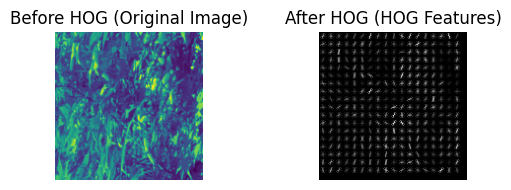

In [100]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color

# Example: Using one image from your dataset
sample_img = data['data'][0]  # Replace with an example image from your dataset

# Convert to grayscale if needed
if len(sample_img.shape) == 3 and sample_img.shape[2] == 3:
    grayscale_img = color.rgb2gray(sample_img)
else:
    grayscale_img = sample_img

# Apply HOG
hog_features, hog_image = hog(grayscale_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                              orientations=9, block_norm='L2-Hys', visualize=True)

# Plot the original and HOG images
plt.figure(figsize=(6, 2))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(grayscale_img)
plt.title('Before HOG (Original Image)')
plt.axis('off')

# HOG image
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title('After HOG (HOG Features)')
plt.axis('off')

plt.tight_layout()
plt.show()

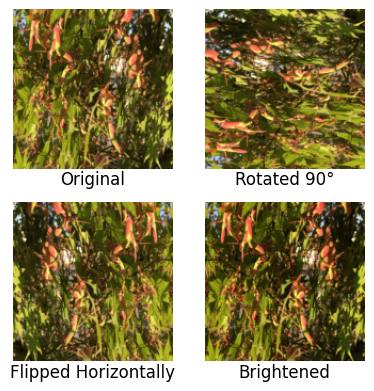

In [104]:
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.exposure import adjust_gamma
import numpy as np

# Sample image from your dataset (replace with actual data)
sample_img = data['data'][0]  # Replace with any image in your dataset

# Generate augmented images
augmented_images = [
    sample_img,
    rotate(sample_img, 90),
    np.fliplr(sample_img),
    adjust_gamma(sample_img, gamma=1.2)
]

# Captions for augmented images
captions = ["Original", "Rotated 90°", "Flipped Horizontally", "Brightened"]

# Create a 2x2 grid with captions below each image
plt.figure(figsize=(4, 4))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    if len(augmented_images[i].shape) == 3 and augmented_images[i].shape[2] == 3:
        plt.imshow(augmented_images[i])  # Display RGB images
    else:
        plt.imshow(augmented_images[i], cmap='gray')  # Grayscale images
    plt.axis('off')
    plt.text(0.5, -0.1, captions[i], size=12, ha="center", transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

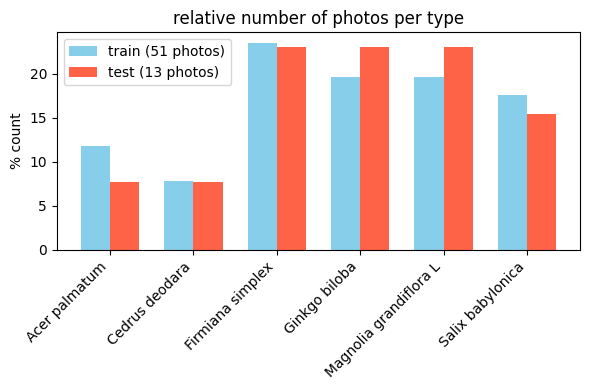

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Step 1: Load the processed data (from your notebook)
import joblib
import os

# Assuming the .pkl file was saved as "leaf_dataset_6classes_150x150px.pkl"
data = joblib.load("leaf_dataset_6classes_150x150px.pkl")

# Extract labels
labels = data['label']
unique_classes = sorted(set(labels))  # ['Acer_palmatum', 'Cedrus_deodara', ...]

# Step 2: Calculate the counts for each class
class_counts = {cls: labels.count(cls) for cls in unique_classes}
total_images = len(labels)  # 64 images

# Step 3: Simulate a train-test split (80% train, 20% test)
# Since the notebook doesn't show the split, we'll create one
X = data['data']  # Image data
y = labels        # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Calculate the counts for train and test sets
train_counts = [y_train.count(cls) for cls in unique_classes]
test_counts = [y_test.count(cls) for cls in unique_classes]

# Step 5: Calculate the percentage counts (relative number of photos)
train_percentages = [(count / len(y_train)) * 100 for count in train_counts]
test_percentages = [(count / len(y_test)) * 100 for count in test_counts]

# Step 6: Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4))

# Set the positions of the bars
x = np.arange(len(unique_classes))
width = 0.35  # Width of the bars

# Plot bars for train and test
ax.bar(x - width/2, train_percentages, width, label=f'train ({len(y_train)} photos)', color='skyblue')
ax.bar(x + width/2, test_percentages, width, label=f'test ({len(y_test)} photos)', color='tomato')

# Customize the plot
ax.set_ylabel('% count')
ax.set_title('relative number of photos per type')
ax.set_xticks(x)
ax.set_xticklabels([cls.replace('_', ' ') for cls in unique_classes], rotation=45, ha='right')
ax.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()